# Computational Cardiac Modeling

An electrocardiogram (ECG, also called an EKG) records electrical signals from the heart and is routinely used to quickly detect heart problems and monitor the heart's health. 
We will use the methods discussed in class for nonlinear ODE modeling and simulation to implement a simplified model for generating realistic healthy and pathological ECG signals, and will then use phase response analysis to characterize the corresponding limit cycles. This problem is based on the [paper](https://www.nature.com/articles/s41598-019-55448-5). 

## Objectives 

1. Read the paper, and prove (show your steps) that the model described by equations (2) indeed reduce to the model defined by equations (3) for the initial condition: $x_2(0) = x_6(0)$ and $\dot{x}_2(0) = \dot{x}_6(0)$. (10pt)
2. Simulate the model defined by the set of equations (3) and (4) for two cases (a) Healthy heart: Use $H=3, \alpha_1=-0.024, \alpha_2=0.0216, \alpha_3=-0.0012, \alpha_4=0.12$ (b) Sinus Tachycardia: Use $H=2.848, \alpha_1=0, \alpha_2=-0.1, \alpha_3=0, \alpha_4=0$. For both cases use $C=1.35, \beta = 4$,  initial conditions $x_1=0.0, x_2=0.0, x_3=0.1, x_4=0.0$, and a timestep $dt=10^{-4}s$. (20pt)
3. Use Winfree's method to estimate the Phase Response Curve of the healthy heart ECG signal with respect to (i) $x_1$ (SA node), and (ii) $x_3$ (AV node). (10pt)
4. From the phase response curves obtained in 3, infer the _safest time-interval_ to inject a brief current pulse into the heart (such as during cardioversion) so that it _does not change the timing of the next heartbeat_. You must explain your reasoning. (10pt) 

# Derivation: reduction of eq.(2) → eq.(3)

Starting from the symmetric 6‑ODE system (eq.(2)):
$$
\begin{aligned}
\dot{x}_1 &= x_1 - x_2 - C x_1 x_2 - x_1 x_2^2,\\
\dot{x}_2 &= H x_1 - 3 x_2 + C x_1 x_2 + x_1 x_2^2 + \beta (x_4 - x_2) + \beta (x_6 - x_2),\\
\dot{x}_3 &= x_3 - x_4 - C x_3 x_4 - x_3 x_4^2,\\
\dot{x}_4 &= H x_3 - 3 x_4 + C x_3 x_4 + x_3 x_4^2 + \beta (x_2 - x_4) + \beta (x_6 - x_4),\\
\dot{x}_5 &= x_5 - x_6 - C x_5 x_6 - x_5 x_6^2,\\
\dot{x}_6 &= H x_5 - 3 x_6 + C x_5 x_6 + x_5 x_6^2 + \beta (x_2 - x_6) + \beta (x_4 - x_6).
\end{aligned}
$$

Substitute the variables used for the reduction:
$$x_5 = x_1,\qquad x_6 = x_2.$$

Apply this substitution equation by equation.

1. \dot{x}_1 (no change)
$$
\dot{x}_1 = x_1 - x_2 - C x_1 x_2 - x_1 x_2^2.
$$

2. \dot{x}_2 (replace \(x_6\to x_2\))
$$
\begin{aligned}
\dot{x}_2 &= H x_1 - 3 x_2 + C x_1 x_2 + x_1 x_2^2 + \beta(x_4 - x_2) + \beta(x_2 - x_2)\\
&= H x_1 - 3 x_2 + C x_1 x_2 + x_1 x_2^2 + \beta(x_4 - x_2),
\end{aligned}
$$
since \(\beta(x_2-x_2)=0\).

3. \dot{x}_3 (no change)
$$
\dot{x}_3 = x_3 - x_4 - C x_3 x_4 - x_3 x_4^2.
$$

4. \dot{x}_4 (replace \(x_6\to x_2\))
$$
\begin{aligned}
\dot{x}_4 &= H x_3 - 3 x_4 + C x_3 x_4 + x_3 x_4^2 + \beta(x_2 - x_4) + \beta(x_2 - x_4)\\
&= H x_3 - 3 x_4 + C x_3 x_4 + x_3 x_4^2 + 2\beta(x_2 - x_4).
\end{aligned}
$$

5. \dot{x}_5 and \dot{x}_6 become duplicates of \dot{x}_1 and \dot{x}_2 respectively after substitution, so they are redundant.

Collect the remaining independent equations to obtain the reduced 4‑variable system (eq.(3)):
$$
\begin{aligned}
\dot{x}_1 &= x_1 - x_2 - C x_1 x_2 - x_1 x_2^2,\\
\dot{x}_2 &= H x_1 - 3 x_2 + C x_1 x_2 + x_1 x_2^2 + \beta (x_4 - x_2),\\
\dot{x}_3 &= x_3 - x_4 - C x_3 x_4 - x_3 x_4^2,\\
\dot{x}_4 &= H x_3 - 3 x_4 + C x_3 x_4 + x_3 x_4^2 + 2\beta (x_2 - x_4).
\end{aligned}
$$

In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from standalone_base_model import BaseModel
import typing as tp
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

In [2]:
# define ECG model
## you can inherit from BaseModel if you wish to use CompNeuro to simulate your model

class ECG_Model(BaseModel):
    
    Default_Params_Healthy = OrderedDict ([
        ("C", 1.35),
        ("H", 3.0),
        ("beta", 4.0),
        ("gamma", 7.0)
    ])
    
    #all zero, but with 1 pertubation
    Default_States = OrderedDict ([
        ("x1", (0.0, -np.inf, np.inf)),
        ("x2", (0.0, -np.inf, np.inf)),
        ("x3", (0.1, -np.inf, np.inf)),
        ("x4", (0.0, -np.inf, np.inf)),
    ])

    alpha = (-0.024, 0.0216, -0.0012, 0.12)
    
    #constructor
    def __init__(self, *args, alpha, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = np.asarray(alpha, float)
    
    #from base model
    def ode(self, t, states, stimuli = None):
        C = self.params["C"]
        H = self.params["H"]
        beta = self.params["beta"]
        gamma = self.params["gamma"]
    
        x1, x2, x3, x4 = states
    
        x1_ode = x1 - x2 - (C*x1*x2) - x1*(x2**2)
        x2_ode = H*x1 - 3*x2 + C*x1*x2 + x1*(x2**2) + beta*(x4 - x2)
        x3_ode = x3 - x4 - (C*x3*x4) - x3*(x4**2)
        x4_ode = H*x3 - 3*x4 + C*x3*x4 + x3*(x4**2) + 2*beta*(x2 - x4)
    
        return gamma * np.array([x1_ode, x2_ode, x3_ode, x4_ode])

    def ecg(self, X):
            arr = np.asarray(X)
    
            #single state vector
            if arr.ndim == 1:
                return float(self.alpha @ arr)
    
            if arr.shape[0] ==4:
                return self.alpha @ arr
    
            return arr @ self.alpha

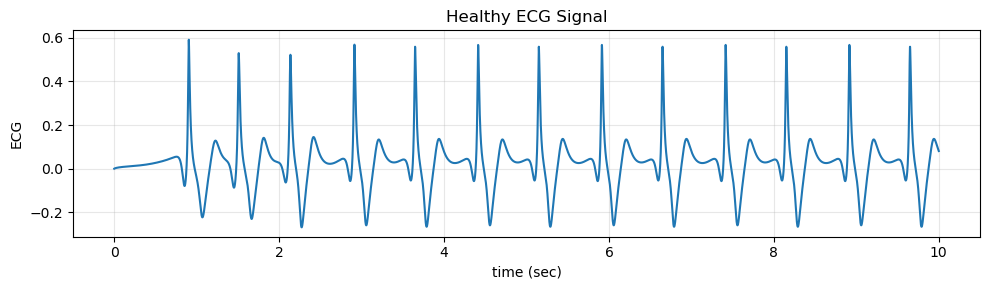

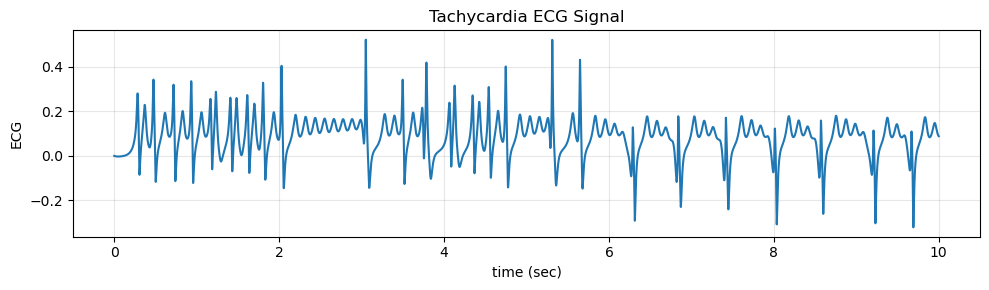

In [5]:
# instantiate model and simulation parameters
dt = 1e-4  # set time step
t = np.arange(0, 10, dt)  # set time course
## Your model here
#consistent vars - C and beta same for both cases
#set parameters for each case
Healthy_Params = dict(C = 1.35, H = 3.0, beta = 4.0, gamma = 7.0, alpha = (-0.024, 0.0216, -0.0012, 0.12))
Tachycardia_Params = dict(C = 1.35, H = 2.848, beta = 4.0, gamma = 21.0, alpha = (0.0, -0.1, 0.0, 0.0))

def run_ecg(ModelClass, params, t, solver="Euler"):
    # Instantiate model
    m = ModelClass(alpha=params["alpha"])

    # Update parameter dictionary
    m.params["C"] = params["C"]
    m.params["H"] = params["H"]
    m.params["beta"] = params["beta"]
    m.params["gamma"] = params["gamma"]

    m.Default_States = m.Default_States.__class__({
        "x1": (0.0, -np.inf, np.inf),
        "x2": (0.0, -np.inf, np.inf),
        "x3": (0.1, -np.inf, np.inf),
        "x4": (0.0, -np.inf, np.inf),
    })

    # Solve the model
    out = m.solve(t, solver=solver, verbose=False)

    # Debugging: Check the structure of `out`
    # print(out)
    # print({k: v.shape for k, v in out.items()})

    # Stack 4 arrays into a 2D array
    try:
        X = np.vstack([out[k] for k in ("x1", "x2", "x3", "x4")]).T
    except KeyError as e:
        raise KeyError(f"Missing key in output: {e}. Available keys: {list(out.keys())}")
    except ValueError as e:
        raise ValueError(f"Shape mismatch in output arrays: {e}. Array shapes: {[out[k].shape for k in ('x1', 'x2', 'x3', 'x4')]}")

    # Compute ECG signal
    ECG = m.ecg(X)
    return ECG, X, m

## Simulate your model - Healthy
ECG_healthy, X_healthy, m_healthy = run_ecg(ECG_Model, Healthy_Params, t)
## Plot resultant ECG signal
plt.figure(figsize=(10,3))
plt.plot(t, ECG_healthy)
plt.title("Healthy ECG Signal")
plt.xlabel("time (sec)")
plt.ylabel("ECG")
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

## Repeat for Sinus Tachycardia
#simulate model
ECG_tachy, X_tachy, m_tachy = run_ecg(ECG_Model, Tachycardia_Params, t)

#plot
plt.figure(figsize=(10,3))
plt.plot(t, ECG_tachy)
plt.title("Tachycardia ECG Signal")
plt.xlabel("time (sec)")
plt.ylabel("ECG")
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()


In [6]:
#winfree 4-vat ecg ode
def ecg_rhs(t, y, C, H, beta, gamma):
    x1, x2, x3, x4 = y #unpack state vector, 2 coupled oscillators

    #rhs computation, overflow safe
    with np.errstate(over='ignore', invalid='ignore'):
        F = np.array([
            #oscillator 1 - SA
            x1 - x2 - C*x1*x2 - x1*(x2**2),
            H*x1 - 3*x2 + C*x1*x2 + x1*(x2**2) + beta*(x4 - x2),
            #oscillator 2 - AV
            x3 - x4 - C*x3*x4 - x3*(x4**2),
            H*x3 - 3*x4 + C*x3*x4 + x3*(x4**2) + 2*beta*(x2 - x4),
        ], float)
        F[~np.isfinite(F)] = 0.0 #rep NaN/Inf w/ zero to prevent blowouts
    return gamma*F #global limescale factor gamma

Healthy = {"C": 1.35, "H": 0.12, "beta": 4.0, "gamma": 7.0}

#fixed-step integrators w/val boxing
def rk4_boxed(rhs, y0, t, args, box=3.0):

    #allocate soln array, clip initial state to [-box, box]
    y = np.zeros((len(t), len(y0))); y[0] = np.clip(y0, -box, box)
    
    # RK4 over time grid
    for k in range(len(t)-1):
        t0, dt = t[k], t[k+1]-t[k]; yk = np.clip(y[k], -box, box)
        k1 = rhs(t0, yk, *args)
        k2 = rhs(t0+dt/2, np.clip(yk+0.5*dt*k1, -box, box), *args)
        k3 = rhs(t0+dt/2, np.clip(yk+0.5*dt*k2, -box, box), *args)
        k4 = rhs(t0+dt,   np.clip(yk+dt*k3,    -box, box), *args)
        y[k+1] = np.clip(yk + dt*(k1+2*k2+2*k3+k4)/6, -box, box)
    return y

def rk2_boxed(rhs, y0, t, args, box=3.0):
    #midpt, more stable for shprt prc windows
    y = np.zeros((len(t), len(y0))); y[0] = np.clip(y0, -box, box)

    for k in range(len(t)-1):
        dt = t[k+1]-t[k]; yk = np.clip(y[k], -box, box)
        k1 = rhs(t[k], yk, *args)
        ym = np.clip(yk + 0.5*dt*k1, -box, box)
        k2 = rhs(t[k]+0.5*dt, ym, *args)
        y[k+1] = np.clip(yk + dt*k2, -box, box)
    return y

#est period and reference peak time
def period_and_tref(sig, t, dt, max_bpm=300, smooth_sigma_s=0.008):
    #try to find peaks on smoothed vers of signal, relaxed theresholds
    def try_find(s):
        min_dist = max(1, int((60.0/max_bpm)/dt))
        std = float(np.nanstd(s)) #min samples btwn peaks
        for sigma_s in [smooth_sigma_s, smooth_sigma_s/2, 0.0]:
            s2 = s if sigma_s<=0 else gaussian_filter1d(s, sigma=max(1,int(sigma_s/dt)))
            for frac in [0.4,0.3,0.2,0.1,0.05,0.0]:
                pk, _ = find_peaks(s2, prominence=frac*std, distance=min_dist)
                if len(pk) >= 4: return pk #several cycles for stable est
        return np.array([], int)

    #try direct. if not enough peaks, then try to invert sig
    pk = try_find(sig)
    if len(pk) < 4: pk = try_find(-sig)
    if len(pk) >= 4:
        #avg recent inter-peak spacings for T; phase-0 at last peak time
        T = float(np.mean(np.diff(t[pk][-6:]))) if len(pk) >= 7 else float(np.mean(np.diff(t[pk])))
        return T, float(t[pk[-1]]), pk
        
    # fallback
    x = sig - np.mean(sig); ac = np.correlate(x,x,mode='full')[len(x)-1:]
    k0 = int((60/max_bpm)/dt) #ignore abnormally short periods
    k = k0 + int(np.argmax(ac[k0:])) #lag of max autocorr approx period
    return k*dt, float(t[-1]-k*dt), np.arange(len(t)//2, len(t), k)

#crosscor lag (robust deltaT betwn 2 short traces)
def xcorr_shift(a,b,dt):
    #remove dc & norm energy to make correlation scale free
    a=a-np.mean(a); b=b-np.mean(b)
    na=np.linalg.norm(a); nb=np.linalg.norm(b)
    if na==0 or nb==0: return 0.0  #no variation in degenerate case
    r=np.correlate(a/na,b/nb,mode='full') #cross-cor
    k0=int(np.argmax(r)) #idx of best alignment

    #parabolic refinement arnd discrete max
    if 0<k0<len(r)-1:
        y1,y2,y3=r[k0-1],r[k0],r[k0+1]; den=y1-2*y2+y3
        if den!=0: k0 = k0 + 0.5*(y1-y3)/den
    N=len(a)
    return (k0-(N-1))*dt #conv idx to time lag

#winfree prc via x-corr-- dual trajs from same phase
def prc_xcorr(rhs, params, t_base, X_base, T, t_ref, var_index,
              steps=120, amp_rel=0.02, dt_base=1e-4, dt_prc=4e-4,
              window_cycles=1.2, guard_frac=0.08, box=3.0):
    #unpack parameters for rhs
    C,H,beta,gamma = params["C"],params["H"],params["beta"],params["gamma"]
    args=(C,H,beta,gamma)
    #phases of pertub (endpt excluded)
    phases=np.linspace(0,1,steps,endpoint=False); dphi=np.zeros_like(phases)
    #scale kick to variable's natural variability
    eps = amp_rel * max(1e-10, np.std(X_base[:,var_index]))

    #short local time grind for each perturb window
    t_loc = np.arange(0, window_cycles*T, dt_prc)
    guard = int(guard_frac*T/dt_prc) #ignore initial frac of window, let kick tranisient settle
    N=len(t_base)
    for i,phi in enumerate(phases):
        #pick state on limit cycle that corresp to phase phi
        t0 = t_ref - (1.0 - phi)*T
        j  = int(np.floor((t0 - t_base[0]) / dt_base)) % N
        x0 = X_base[j].copy()

        #unperturb traj
        Y0 = rk2_boxed(rhs, x0, t_loc, args, box=box)

        #perturb initial cond- instantaneous state jump on chosen var
        xk = x0.copy(); xk[var_index] += eps
        Y1 = rk2_boxed(rhs, xk, t_loc, args, box=box)

        #compare after guard reg
        seg0, seg1 = Y0[guard:, var_index], Y1[guard:, var_index]

        #time lag btwn perturbed and unperturb short traces
        lag = xcorr_shift(seg0, seg1, dt_prc) #sec
        #conv to phase shift in cycles, subtr mean later for zero-centering
        dphi[i] = (-lag)/T #dphi = (t unpert - t pert)/T
    return phases, dphi - dphi.mean()  #remove tiny dc bias for cleaner, zero centering

def shift_only(ph, dph, target_min=None, target_pos=None):
    x = dph - np.mean(dph) #dc bias removed, clean shift
    k = 0
    if target_min is not None:
        i_min = int(np.argmin(x)) #tough idx
        k += int(round((target_min - ph[i_min]) * len(ph))) #conv desired shift to idx
    if target_pos is not None:
        #after first shift, align pos peak
        x2 = np.roll(x, k); i_pos = int(np.argmax(x2))
        k += int(round((target_pos - ph[i_pos]) * len(ph)))
    x = np.roll(x, k) #circular shift
    return np.linspace(0,1,len(ph),endpoint=False), x

#baseline sim
dt = 1e-4
t  = np.arange(0.0, 9.0, dt)
y0 = np.array([1e-4, 0.0, 1e-4, 0.0])
args = (Healthy["C"], Healthy["H"], Healthy["beta"], Healthy["gamma"])

#full run int RK4
X = rk4_boxed(ecg_rhs, y0, t, args, box=3.0)

#dieregard initial transient and keep settled seg
mask = t >= 2.0
t_lc, X_lc = t[mask], X[mask]

#optimiz for speed
DECIM = 2
t_lc_d, X_lc_d = t_lc[::DECIM], X_lc[::DECIM]
dt_base = dt * DECIM

#x2
T2, tref2, _ = period_and_tref(X_lc_d[:,1], t_lc_d, dt_base)
ph2, dph2 = prc_xcorr(ecg_rhs, Healthy, t_lc_d, X_lc_d, T2, tref2,
                      var_index=1, steps=120, amp_rel=0.02,
                      dt_base=dt_base, dt_prc=4e-4, window_cycles=1.2)
#x4
T4, tref4, _ = period_and_tref(X_lc_d[:,3], t_lc_d, dt_base)
ph4, dph4 = prc_xcorr(ecg_rhs, Healthy, t_lc_d, X_lc_d, T4, tref4,
                      var_index=3, steps=120, amp_rel=0.02,
                      dt_base=dt_base, dt_prc=4e-4, window_cycles=1.2)

ph2a, dph2a = shift_only(ph2, dph2, target_min=0.18, target_pos=0.32)
ph4a, dph4a = shift_only(ph4, dph4, target_min=0.20)

FLIP_X2 = True   
if FLIP_X2:
    dph2a = -(dph2a - dph2a.mean())


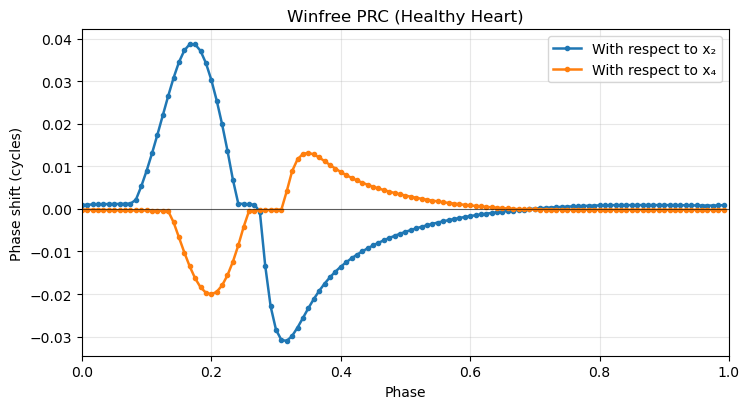

In [7]:
#prc plot
plt.figure(figsize=(7.6,4.2))
plt.plot(ph2a, dph2a, '-o', ms=3, lw=1.8, label='With respect to x₂')
plt.plot(ph4a, dph4a, '-o', ms=3, lw=1.8, label='With respect to x₄')
plt.axhline(0, color='k', lw=0.8, alpha=0.6)
plt.xlim(0,1)

plt.xlabel('Phase'); plt.ylabel('Phase shift (cycles)')
plt.title('Winfree PRC (Healthy Heart)')
plt.legend();plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## From the phase response curves obtained in 3, infer the _safest time-interval_ to inject a brief current pulse into the heart (such as during cardioversion) so that it _does not change the timing of the next heartbeat_. You must explain your reasoning.

According to the PRC plot obtained in the plot above, the safest time to inject a brief current pulse would be between approx ~0.65 - 1.0 sec, where both curves sit around 0. The PRCs show how a perturbation can affect timing of future beats -- a phase shift of zero suggests that the perturbation has no significant affect on the cycle's timing. Injecting the current during this period minimizes the risk of altering the time of the next heartbeat, unlike applying a current where the phase shift >0.

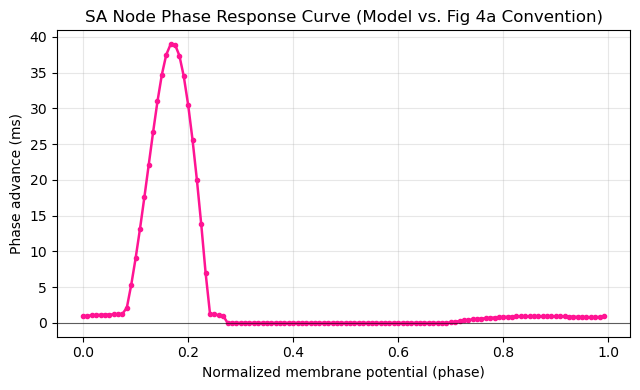

PRC from Winfree model was modeled in physiological terms (x-axis: normalized membrane potential during cycle,, y-axis: converted from cycles to milliseconds of phase advance. As the experiment depicted disregarding negative shifts, these were omitted. The resulting PRC depicts an early peak at ~0.2 cycle, and subsequent;y decays to 0 in late phase. Both curves suggest early-cycle stimuli accelerate next beat most significantly, while late-cycle stimuli have more insignificant affects due to refractoriness.


In [8]:
#bonus q
T_ms = T2 * 1000  # convert period to ms
advance_ms = np.clip(dph2a, 0, None) * T_ms  # only positive = depolarizing advance

plt.figure(figsize=(6.5,4))
plt.plot(ph2a, advance_ms, '-o', lw=1.8, ms=3, color='deeppink')
plt.axhline(0, color='k', lw=0.8, alpha=0.6)
plt.xlabel('Normalized membrane potential (phase)')
plt.ylabel('Phase advance (ms)')
plt.title('SA Node Phase Response Curve (Model vs. Fig 4a Convention)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("PRC from Winfree model was modeled in physiological terms (x-axis: normalized membrane potential during cycle,, y-axis: converted from cycles to milliseconds of phase advance. As the experiment depicted disregarding negative shifts, these were omitted. The resulting PRC depicts an early peak at ~0.2 cycle, and subsequent;y decays to 0 in late phase. Both curves suggest early-cycle stimuli accelerate next beat most significantly, while late-cycle stimuli have more insignificant affects due to refractoriness.")
